In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import os

In [22]:
def create_sequences(data, targets, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(targets[i + window_size])
    return np.array(X), np.array(y)

In [23]:
def add_temporal_features(df):
    df['HourSin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['HourCos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['DaySin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayCos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['MonthSin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['MonthCos'] = np.cos(2 * np.pi * df['Month'] / 12)
    return df

In [24]:
def add_lagged_features(df, target_column, lags):
    for lag in lags:
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df.dropna()

In [25]:
def load_and_preprocess_data(files, sheets):
    df_list = []
    
    for file in files:
        if os.path.exists(file):
            for sheet in sheets:
                try:
                    temp_df = pd.read_excel(file, sheet_name=sheet)
                    
                    if 'TRAFFIC STATUS' in temp_df.columns:
                        temp_df.drop(columns=['TRAFFIC STATUS'], inplace=True)
                    
                    temp_df['TIME(24 HOUR)'] = temp_df['TIME(24 HOUR)'].astype(str).str.zfill(5) + ':00'
                    temp_df['Datetime'] = pd.to_datetime(
                        temp_df['DATE'].astype(str) + ' ' + temp_df['TIME(24 HOUR)'],
                        dayfirst=True, errors='coerce'
                    )
                    
                    temp_df = temp_df.dropna(subset=['Datetime']).sort_values('Datetime')
                    temp_df['Hour'] = temp_df['Datetime'].dt.hour
                    temp_df['DayOfWeek'] = temp_df['Datetime'].dt.dayofweek
                    temp_df['Month'] = temp_df['Datetime'].dt.month
                    temp_df = add_temporal_features(temp_df)
                    
                    df_list.append(temp_df)
                except Exception as e:
                    print(f"Error loading {file} - {sheet}: {e}")
    
    return pd.concat(df_list, ignore_index=True) if df_list else None

In [26]:
files = ['./dataset/MA-A.xlsx', './dataset/NORTHBOUND.xlsx', './dataset/SOUTHBOUND.xlsx']
sheets = ["2018", "2019", "2020", "2021", "2022", "2023"]
df = load_and_preprocess_data(files, sheets)

df.head()

,DATE,TIME(24 HOUR),DAY OF THE WEEK,WEATHER,ROAD CONDITION,HOLIDAY,ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,HourSin,HourCos,DaySin,DayCos,MonthSin,MonthCos
0,01/01/2018,00:00:00,Monday,Passing Clouds,Dry,YES,0,36,224,2018-01-01 00:00:00,0,0,1,0.000000,1.000000,0.0,1.0,0.5,0.866025
1,01/01/2018,01:00:00,Monday,Passing Clouds,Dry,YES,0,27,171,2018-01-01 01:00:00,1,0,1,0.258819,0.965926,0.0,1.0,0.5,0.866025
2,01/01/2018,02:00:00,Monday,Passing Clouds,Dry,YES,0,24,119,2018-01-01 02:00:00,2,0,1,0.500000,0.866025,0.0,1.0,0.5,0.866025
3,01/01/2018,03:00:00,Monday,Passing Clouds,Dry,YES,0,22,173,2018-01-01 03:00:00,3,0,1,0.707107,0.707107,0.0,1.0,0.5,0.866025
4,01/01/2018,04:00:00,Monday,Passing Clouds,Dry,YES,0,38,168,2018-01-01 04:00:00,4,0,1,0.866025,0.500000,0.0,1.0,0.5,0.866025


In [27]:
categorical_cols = ['DAY OF THE WEEK', 'WEATHER', 'ROAD CONDITION', 'HOLIDAY']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

target_column = 'TRAFFIC VOLUME'
lags = [1, 2, 3, 6, 12, 24]
df = add_lagged_features(df, target_column, lags)

features = df.drop([target_column, 'DATE', 'TIME(24 HOUR)', 'Datetime'], axis=1)
target = df[target_column]

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1)).flatten()

window_size = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

df.head()

,DATE,TIME(24 HOUR),ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,HourSin,...,WEATHER_Sunny,WEATHER_Thunderstorm,ROAD CONDITION_Wet,HOLIDAY_YES,TRAFFIC VOLUME_lag_1,TRAFFIC VOLUME_lag_2,TRAFFIC VOLUME_lag_3,TRAFFIC VOLUME_lag_6,TRAFFIC VOLUME_lag_12,TRAFFIC VOLUME_lag_24
24,02/01/2018,00:00:00,0,31,223,2018-01-02 00:00:00,0,1,1,0.000000,...,False,False,False,False,295.0,354.0,365.0,1590.0,974.0,224.0
25,02/01/2018,01:00:00,0,28,210,2018-01-02 01:00:00,1,1,1,0.258819,...,False,False,False,False,223.0,295.0,354.0,364.0,978.0,171.0
26,02/01/2018,02:00:00,0,29,233,2018-01-02 02:00:00,2,1,1,0.500000,...,False,False,False,False,210.0,223.0,295.0,527.0,1398.0,119.0
27,02/01/2018,03:00:00,0,34,230,2018-01-02 03:00:00,3,1,1,0.707107,...,False,False,False,False,233.0,210.0,223.0,365.0,1083.0,173.0
28,02/01/2018,04:00:00,0,28,255,2018-01-02 04:00:00,4,1,1,0.866025,...,False,False,False,False,230.0,233.0,210.0,354.0,1576.0,168.0


In [28]:
model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.3),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop],
    verbose=1
)

y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

Epoch 1/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - loss: 0.1799 - mae: 0.0736 - val_loss: 0.0120 - val_mae: 0.0684
Epoch 2/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - loss: 0.0053 - mae: 0.0487 - val_loss: 0.0084 - val_mae: 0.0561
Epoch 3/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0043 - mae: 0.0433 - val_loss: 0.0097 - val_mae: 0.0596
Epoch 4/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.0037 - mae: 0.0402 - val_loss: 0.0063 - val_mae: 0.0512
Epoch 5/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0033 - mae: 0.0379 - val_loss: 0.0065 - val_mae: 0.0517
Epoch 6/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0032 - mae: 0.0368 - val_loss: 0.0089 - val_mae: 0.0571
Epoch 7/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0029 - mae: 0.0352 - val_loss: 0.0063 - val_mae: 0.0494
Epoch 8/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0028 - mae: 0.0339 - val_loss: 0.0070 - val_mae: 0.0513
Epoch 9/100
544/544 ━━━━━━━━━━━━

In [29]:
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_pred)

print("\nPerformance on training:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


Performance on training:
MAE: 251.1552
MSE: 105659.3802
RMSE: 325.0529
R2 Score: 0.9431


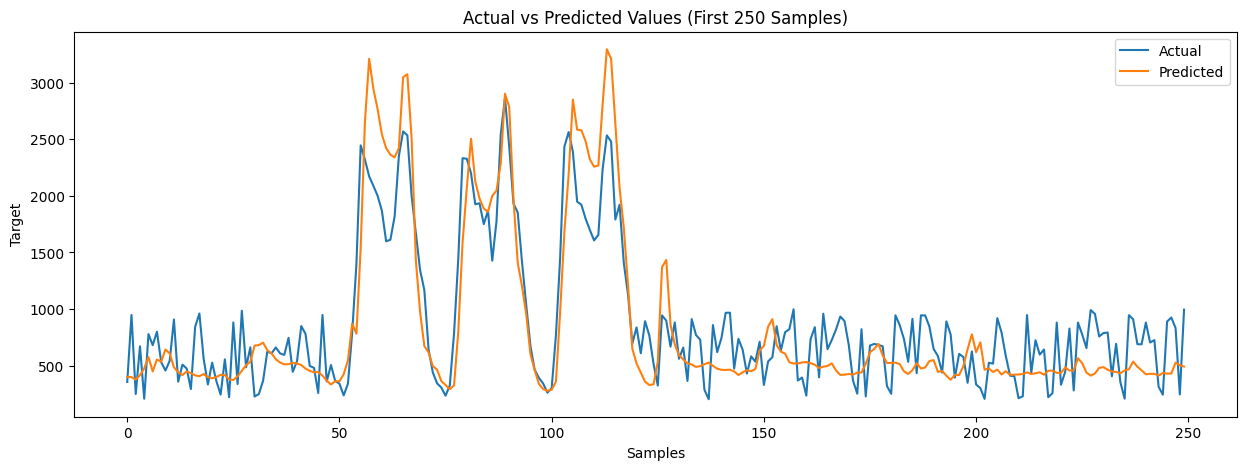

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[:250], label="Actual")
plt.plot(y_pred[:250], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

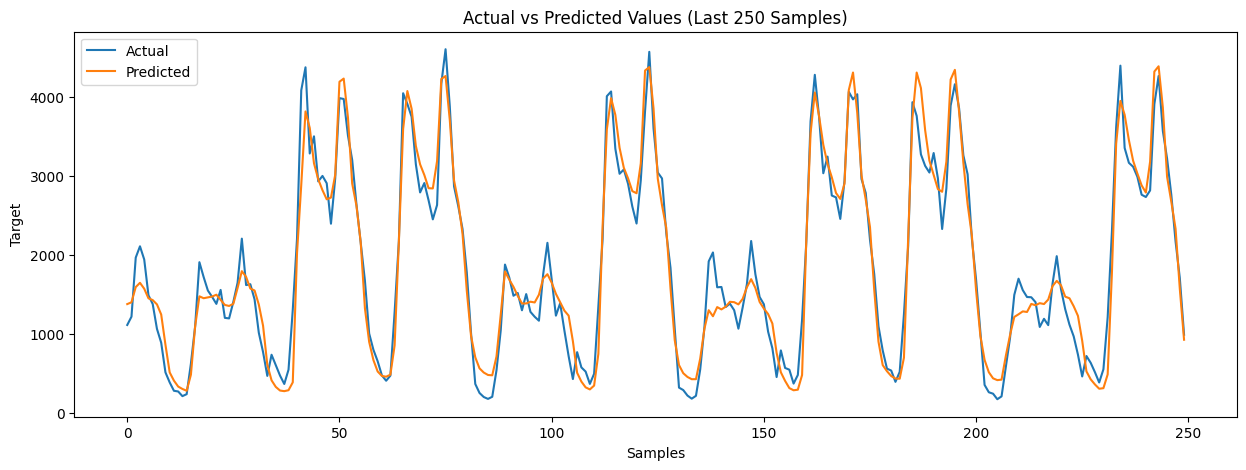

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[-250:], label="Actual")
plt.plot(y_pred[-250:], label="Predicted")
plt.title("Actual vs Predicted Values (Last 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

In [32]:
# Function to preprocess new dataset
def preprocess_new_data(df, scaler_X, scaler_y, window_size):
    df['HourSin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['HourCos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['DaySin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayCos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['MonthSin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['MonthCos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df = pd.get_dummies(df, columns=['DAY OF THE WEEK', 'WEATHER', 'ROAD CONDITION', 'HOLIDAY'], drop_first=True)
    
    target_column = 'TRAFFIC VOLUME'
    lags = [1, 2, 3, 6, 12, 24]
    for lag in lags:
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    df = df.dropna()
    
    features = df.drop([target_column, 'DATE', 'TIME(24 HOUR)', 'Datetime'], axis=1)
    target = df[target_column]
    
    X_scaled = scaler_X.transform(features)
    y_scaled = scaler_y.transform(target.values.reshape(-1, 1)).flatten()
    
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - window_size):
        X_seq.append(X_scaled[i:i + window_size])
        y_seq.append(y_scaled[i + window_size])
    
    return np.array(X_seq), np.array(y_seq), df[target_column].values[window_size:]

In [34]:
# Load new dataset
new_data_file = './dataset/TESTING_DATASET.xlsx'
new_df = pd.read_excel(new_data_file)
if 'TRAFFIC STATUS' in new_df.columns:
    new_df.drop(columns=['TRAFFIC STATUS'], inplace=True)
new_df['ROAD CONDITION'] = new_df['ROAD CONDITION'].str.capitalize()
new_df['TIME(24 HOUR)'] = new_df['TIME(24 HOUR)'].astype(str).str.zfill(5) + ':00'
new_df['Datetime'] = pd.to_datetime(new_df['DATE'].astype(str) + ' ' + new_df['TIME(24 HOUR)'], dayfirst=True, errors='coerce')
new_df = new_df.dropna(subset=['Datetime']).sort_values('Datetime')
new_df['Hour'] = new_df['Datetime'].dt.hour
new_df['DayOfWeek'] = new_df['Datetime'].dt.dayofweek
new_df['Month'] = new_df['Datetime'].dt.month

new_df.head()

,DATE,TIME(24 HOUR),DAY OF THE WEEK,WEATHER,ROAD CONDITION,HOLIDAY,ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month
0,01/01/2016,00:00:00,Friday,Clear,Dry,YES,0,39,342,2016-01-01 00:00:00,0,4,1
1,01/01/2016,01:00:00,Friday,Clear,Dry,YES,0,29,232,2016-01-01 01:00:00,1,4,1
2,01/01/2016,02:00:00,Friday,Clear,Dry,YES,0,39,200,2016-01-01 02:00:00,2,4,1
3,01/01/2016,03:00:00,Friday,Clear,Dry,YES,0,31,183,2016-01-01 03:00:00,3,4,1
4,01/01/2016,04:00:00,Friday,Clear,Dry,YES,0,38,222,2016-01-01 04:00:00,4,4,1


In [35]:
# Preprocess new data
window_size = 24
X_new, y_new, y_actual_new = preprocess_new_data(new_df, scaler_X, scaler_y, window_size)

In [36]:
# Ensure model is in memory
if 'model' not in globals():
    raise ValueError("Trained model not found. Ensure you have trained the model in a previous cell.")

In [37]:
# Make predictions
y_pred_scaled_new = model.predict(X_new).flatten()
y_pred_new = scaler_y.inverse_transform(y_pred_scaled_new.reshape(-1, 1)).flatten()

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 


In [38]:
# Compute metrics
mae_new = mean_absolute_error(y_actual_new, y_pred_new)
mse_new = mean_squared_error(y_actual_new, y_pred_new)
rmse_new = np.sqrt(mean_squared_error(y_actual_new, y_pred_new))
r2_new = r2_score(y_actual_new, y_pred_new)

print("\nPerformance on Testing:")
print(f"MAE: {mae_new:.4f}")
print(f"MSE: {mse_new:.4f}")
print(f"RMSE: {rmse_new:.4f}")
print(f"R2 Score: {r2_new:.4f}")


Performance on Testing:
MAE: 147.3982
MSE: 41054.0625
RMSE: 202.6180
R2 Score: 0.8575


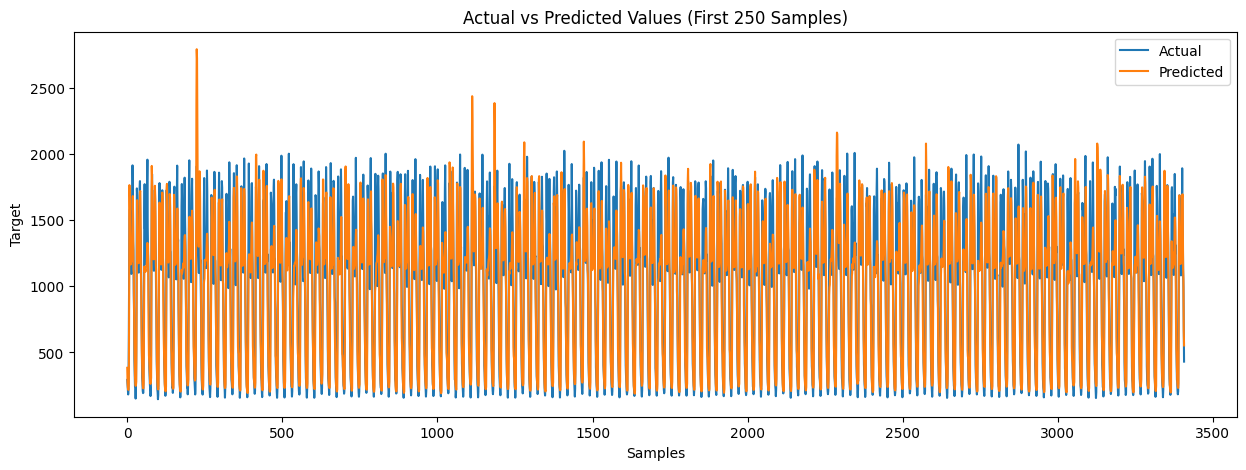

In [43]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual_new, label="Actual")
plt.plot(y_pred_new, label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

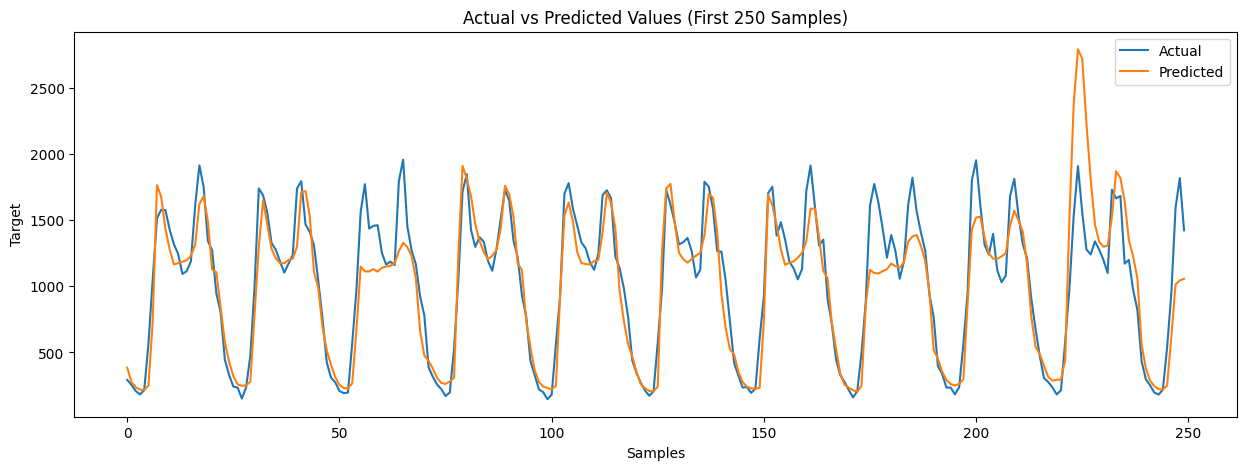

In [42]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual_new[:250], label="Actual")
plt.plot(y_pred_new[:250], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

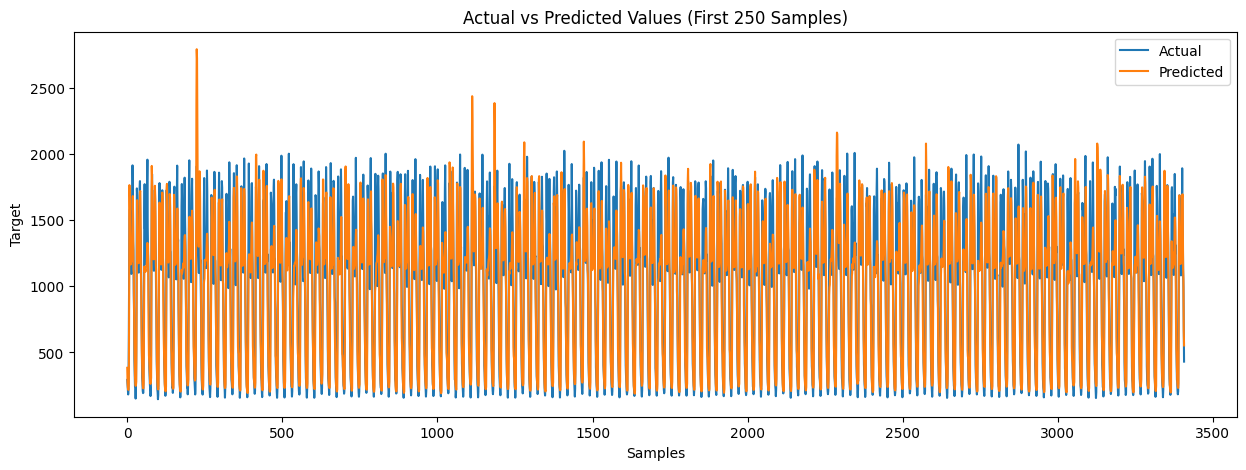

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual_new[-250:], label="Actual")
plt.plot(y_pred_new[-250:], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()